<a href="https://colab.research.google.com/github/edmenciab733/PINV15-673/blob/master/diagnostico_trastornos_edgar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerías 

Se instalan las librerías necesarias
- datasets
- ntlk 
- transformers
- peft


In [94]:
!pip install -q bitsandbytes datasets accelerate loralib
!pip install nltk
!pip install -q git+https://github.com/huggingface/transformers.git@main git+https://github.com/huggingface/peft.git
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Se cargan las librerías necesariás

In [95]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
import numpy as np
from datasets import load_metric
from transformers import Trainer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
import evaluate
from sklearn import metrics
import matplotlib.pyplot as plt

# Dataset
- Se carga stopwords
- Se carga el dataset Sintomas.xlsx
- Se convierte el los padecimientos en una variable númerica llamada Padecimiento_Cat
- Se crean los diccionarios  id2label - label2id para que el pipeline dé los resultados
- Se define el numero de posibles resultados

In [96]:
%%capture
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [97]:
data = pd.read_excel("Sintomas.xlsx")

In [98]:
labelencoder = LabelEncoder()
labelencoder.fit(data['Padecimiento'])
data['Padecimiento_Cat'] = labelencoder.transform(data['Padecimiento'])

In [99]:
labelencoder.transform(['Enuresis'])

array([0])

In [118]:
id2label = {}
label2id = {}
for i in labelencoder.classes_:
   id = labelencoder.transform([i])[0]
   id_aux = str(id)
   id2label[id_aux] = i
   label2id[i] = id_aux

In [119]:
id2label, label2id

({'0': 'Enuresis',
  '1': 'Transtorno del sueño',
  '2': 'Trastorno Depresivo Mayor',
  '3': 'Trastorno de Ansiedad Debido a Otra Afección Médica',
  '4': 'Trastorno de Ansiedad Generalizada',
  '5': 'Trastorno de Ansiedad Social (Fobia Social)',
  '6': 'Trastorno por Abuso de Sustancias',
  '7': 'Trastornos de la conducta alimentaria no especificados',
  '8': 'Trastornos de la personalidad antisocial',
  '9': 'Trastornos de la personalidad borderline',
  '10': 'Trastornos de la personalidad esquizoide',
  '11': 'Trastornos de la personalidad esquizotípica',
  '12': 'Trastornos de la personalidad histriónica',
  '13': 'Trastornos de la personalidad narcisista',
  '14': 'Trastornos de la personalidad paraoide'},
 {'Enuresis': '0',
  'Transtorno del sueño': '1',
  'Trastorno Depresivo Mayor': '2',
  'Trastorno de Ansiedad Debido a Otra Afección Médica': '3',
  'Trastorno de Ansiedad Generalizada': '4',
  'Trastorno de Ansiedad Social (Fobia Social)': '5',
  'Trastorno por Abuso de Sustan

In [121]:
target_nro = len(labelencoder.classes_)
target_nro

15

In [103]:
data.head()

,Síntoma,Padecimiento,Padecimiento_Cat
0,El paciente experimenta preocupación por su co...,Trastornos de la conducta alimentaria no espec...,7
1,La preocupación del paciente por su alimentaci...,Trastornos de la conducta alimentaria no espec...,7
2,El paciente evita comer alimentos que contenga...,Trastornos de la conducta alimentaria no espec...,7
3,La preocupación del paciente por su peso o apa...,Trastornos de la conducta alimentaria no espec...,7
4,El paciente siente rechazo hacia los alimentos...,Trastornos de la conducta alimentaria no espec...,7


Resumen del balance de los datos

In [104]:
data.Padecimiento.value_counts()

Trastornos de la personalidad narcisista                  118
Trastornos de la personalidad histriónica                 100
Trastornos de la personalidad borderline                   98
Trastornos de la personalidad antisocial                   74
Trastornos de la personalidad esquizotípica                70
Enuresis                                                   68
Trastornos de la personalidad esquizoide                   47
Trastorno de Ansiedad Generalizada                         40
Trastorno de Ansiedad Social (Fobia Social)                40
Trastornos de la personalidad paraoide                     37
Trastornos de la conducta alimentaria no especificados     30
Trastorno Depresivo Mayor                                  30
Transtorno del sueño                                       23
Trastorno por Abuso de Sustancias                          20
Trastorno de Ansiedad Debido a Otra Afección Médica        19
Name: Padecimiento, dtype: int64

In [105]:
data = data.sample(frac=1).reset_index(drop=True)

In [106]:
data.head()

,Síntoma,Padecimiento,Padecimiento_Cat
0,Tiene un círculo social muy limitado y no se s...,Trastornos de la personalidad esquizoide,10
1,"Tiene una interacción social inapropiada, que ...",Trastornos de la personalidad histriónica,12
2,Esta persona tiene una gran dificultad para ol...,Trastornos de la personalidad paraoide,14
3,A menudo muestra poco o ningún afecto hacia lo...,Trastornos de la personalidad esquizotípica,11
4,"Su expresión emocional es muy limitada, su ros...",Trastornos de la personalidad histriónica,12


Nube de palabras para establecer los usos entender un poco el dataset

In [107]:
def nube_palabras(all_text): 
  wordcloud = WordCloud(width = 800, height = 800,
                  background_color ='white',
                  stopwords = stopwords,
                  min_font_size = 10).generate(all_text)

  plt.figure(figsize = (8, 8), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)
  plt.show()

In [108]:
stopwords  = set(stopwords.words('spanish'))

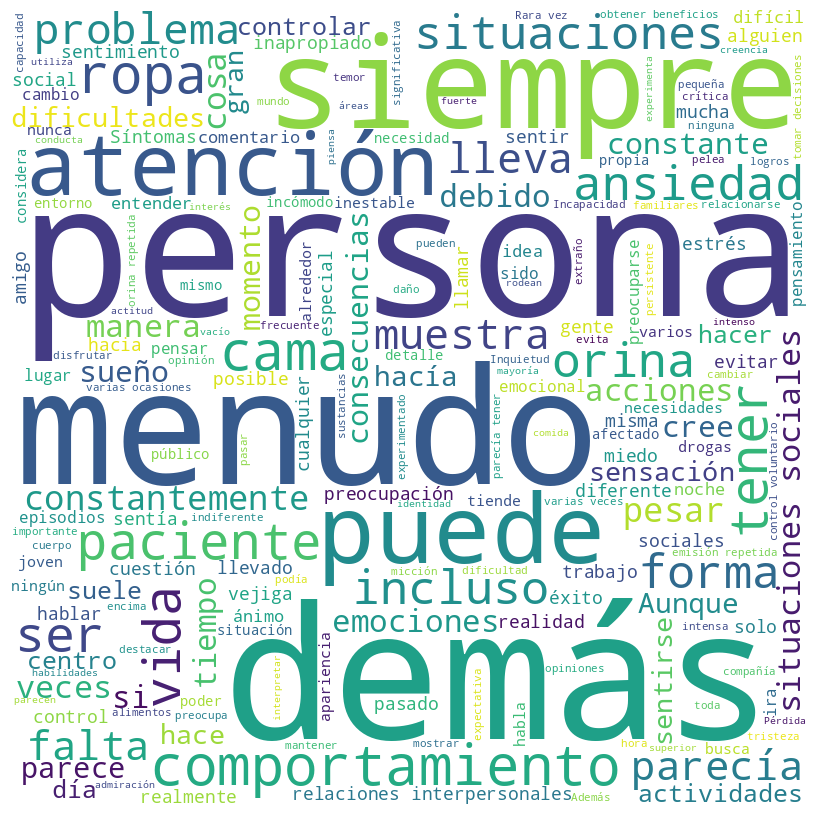

In [109]:
all_text = ' '.join(list(data["Síntoma"].values))
nube_palabras(all_text)
del all_text

# FineTuning
- Conversión de pandas a dataset(hugginface)
- Renombre de las columnas adecuedas
- Split train-test de los datos


In [110]:
dataset = Dataset.from_pandas(data)
dataset = dataset.rename_column("Síntoma", "text")
dataset = dataset.rename_column("Padecimiento_Cat", "label")

In [111]:
dataset= dataset.class_encode_column(
    "label"
).train_test_split(test_size=0.2, stratify_by_column="label")
dataset

Stringifying the column:   0%|          | 0/814 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/814 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'Padecimiento', 'label'],
        num_rows: 651
    })
    test: Dataset({
        features: ['text', 'Padecimiento', 'label'],
        num_rows: 163
    })
})

## Carga de los modelos
-  Carga dccuchile/bert-base-spanish-wwm-cased
-  Preparación de los paramestros de entrenamiento
-  Entrenamiento
-  Guarda de los modelos de entrenamientos


Carga del modelo ber en español

In [112]:
model_id="dccuchile/bert-base-spanish-wwm-cased"

In [113]:
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [114]:
def tokenize_function(examples):
  return tokenizer(examples["text"], padding="max_length", truncation=True)

In [115]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/651 [00:00<?, ? examples/s]

Map:   0%|          | 0/163 [00:00<?, ? examples/s]

In [122]:
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=target_nro, id2label=id2label, label2id=label2id)

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchi

In [123]:
metric = evaluate.load("accuracy")

In [124]:
def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  return metric.compute(predictions=predictions, references=labels)

In [125]:
from transformers import TrainingArguments
training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

In [126]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

In [ ]:
trainer.evaluate(tokenized_datasets["test"])

In [ ]:
predict= trainer.predict(tokenized_datasets["test"])

In [ ]:
preds = np.argmax(predict.predictions, axis=-1)

In [ ]:
df_evaluate = pd.DataFrame(tokenized_datasets["test"] ) 
df_evaluate['prediction'] = preds

In [ ]:
confusion_matrix = metrics.confusion_matrix(df_evaluate['label'], df_evaluate['prediction'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = labelencoder.classes_)
cm_display.plot()
plt.show()

In [34]:
model_id_custom = "./diagnotico_fine_tunning_transformer"
# Save tokenizer
tokenizer.save_pretrained(model_id_custom)
# Save model
trainer.save_model(model_id_custom)

# Testing Model

In [35]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id_custom)
# Load model
loaded_model = AutoModelForSequenceClassification.from_pretrained(model_id_custom)

In [36]:
from transformers import pipeline

In [37]:
classifier = pipeline("text-classification", model=model_id_custom )

In [140]:
classifier("experimenta preocupación por su comida y evita consumir alimentos con alto contenido de grasa.")

[{'label': 'Trastornos de la personalidad histriónica',
  'score': 0.9386147856712341}]

In [136]:
%%capture
!pip install captum

In [151]:
import torch
import pandas as pd

from torch import tensor 

from transformers.pipelines import TextClassificationPipeline
from captum.attr import LayerIntegratedGradients, TokenReferenceBase

import matplotlib.pyplot as plt

class ExplainableTransformerPipeline():
    """Wrapper for Captum framework usage with Huggingface Pipeline"""
    
    def __init__(self, name:str, pipeline: TextClassificationPipeline, device: str):
        self.__name = name
        self.__pipeline = pipeline
        self.__device = device
    
    def forward_func(self, inputs: tensor, position = 0):
        """
            Wrapper around prediction method of pipeline
        """
        pred = self.__pipeline.model(inputs,
                       attention_mask=torch.ones_like(inputs))
        return pred[position]
        
    def visualize(self, inputs: list, attributes: list, prediction: dict):
        """
            Visualization method.
            Takes list of inputs and correspondent attributs for them to visualize in a barplot
        """
        attr_sum = attributes.sum(-1) 
        
        attr = attr_sum / torch.norm(attr_sum)
        
        a = pd.Series(attr.numpy()[0], 
                         index = self.__pipeline.tokenizer.convert_ids_to_tokens(inputs.detach().numpy()[0]))
        
        predicted_label = prediction[0]["label"]

        plt.title(predicted_label)
        
        plt.show(a.plot.barh(figsize=(10,20)))
                      
    def explain(self, text: str):
        """
            Main entry method. Passes text through series of transformations and through the model. 
            Calls visualization method.
        """
        prediction = self.__pipeline.predict(text)
        inputs = self.generate_inputs(text)
        baseline = self.generate_baseline(sequence_len = inputs.shape[1])
        
        lig = LayerIntegratedGradients(self.forward_func, self.__pipeline.model.bert.embeddings)

        label2id = self.__pipeline.model.config.label2id[prediction[0]['label']] 
        label2id = int(label2id)
        attributes, delta = lig.attribute(inputs=inputs,
                                  baselines=baseline,
                                  target = label2id, 
                                  return_convergence_delta = True)
        
        
        
        self.visualize(inputs, attributes, prediction)
        
    def generate_inputs(self, text: str) -> tensor:
        """
            Convenience method for generation of input ids as list of torch tensors
        """
        return torch.tensor(self.__pipeline.tokenizer.encode(text, add_special_tokens=False), device = self.__device).unsqueeze(0)
    
    def generate_baseline(self, sequence_len: int) -> tensor:
        """
            Convenience method for generation of baseline vector as list of torch tensors
        """        
        return torch.tensor([self.__pipeline.tokenizer.cls_token_id] + [self.__pipeline.tokenizer.pad_token_id] * (sequence_len - 2) + [self.__pipeline.tokenizer.sep_token_id], device = self.__device).unsqueeze(0)
    

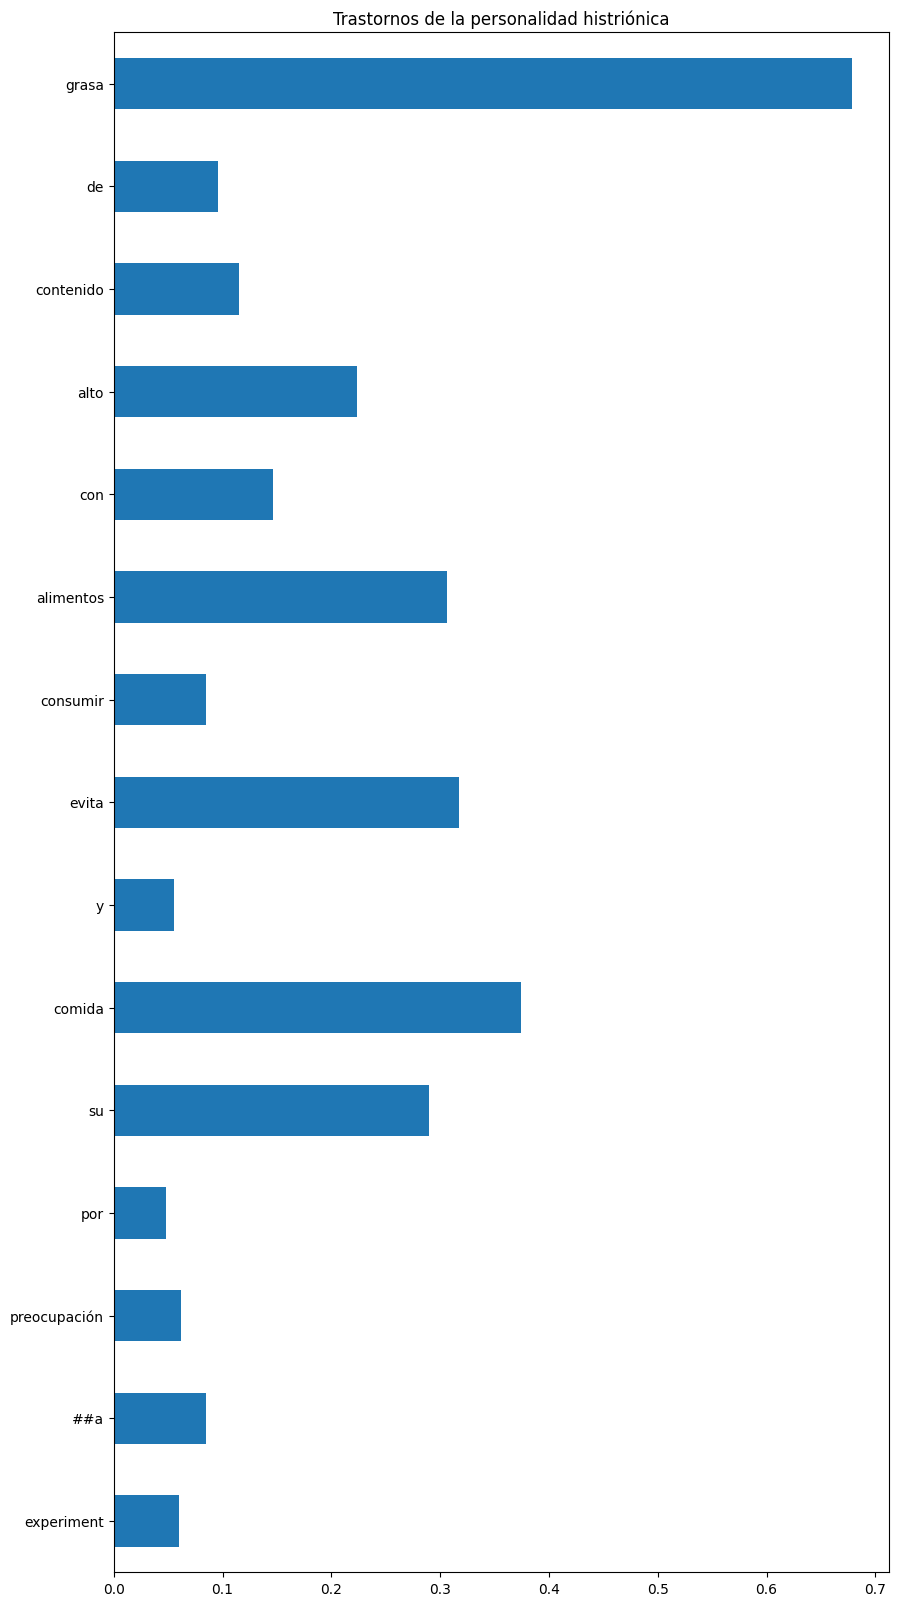

In [154]:
device = "cpu"
sample = "experimenta preocupación por su comida y evita consumir alimentos con alto contenido de grasa"
exp_model = ExplainableTransformerPipeline(model_id_custom, classifier, device)
exp_model.explain(sample)